# Introduction to Spatial Plots

### Author: Chris Wyburn-Powell, find the most up-to-date version on [github](https://github.com/chrisrwp/ATOC_4500) <br>

#### **ATOC 4500-003**, Fall 2021 at CU Boulder. Taught by Professor Alexandra Jahn, and teaching assistant Chris Wyburn-Powell <br>

**This notebook provides an intoduction to plotting spatial data and polar projections** <br>

**New Skills learned:**
- Calcualting statistics on spatial `xarray` datatsets
- Plotting polar projection figures with `cartopy`
- Plotting reduced area figures with `cartopy`

## Prerequisites

Please use the `ATOC_4500_Python_env` by running in your terminal the following commmands replacing <> with your path: <br>
`conda activate </opt/anaconda3/envs/>ATOC_4500_Python_en>` <br>
`jupyter lab` <br>

Please ensure you have downloaded the following files from within `SIC_models_CanESM2_CESM1` from [Google Drive](https://drive.google.com/drive/u/0/folders/1HvYoLNhBrcQP2VvMMH3xqfDt82oysSFR):
- `CanESM2_SIC_1950_2100.zip` Spatial sea ice concentration (SIC) data for CanESM2's 50 members 1950-2100
- `areacello_CanESM2.nc` The area of each of the CanESM2 grid cells
- `CESM1_LE_Baffin_Bay_SIC_07_regrid.nc` SIC data for CESM1 LE 40 members in the Baffin Bay region for years 1920-2100
- `CESM1_LE_areacello_baffin_bay_regrid` Areas of the CESM1 gtid cells

# Tutorial Start

In [40]:
import datetime
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import dask

In [41]:
#change this to your data path!
data_path = '/Users/chwy8767/Downloads/'

# CanESM2 data
**Firstly let's load all 50 of the CanESM2 members as a single xarray dataset**

In [42]:
CanESM2_files = [] #initialize list
member_numbers = np.arange(1,51,1) #we have member numbers 1-50

for mem_i in member_numbers: #loop through the 50 members
    temp_file = xr.open_dataset(data_path+'CanESM2_SIC_1950_2100/sic_OImon_CanESM2_historical_rcp85_r{}i1p1_195001-210012.nc'.format(mem_i), chunks=25)
    CanESM2_files.append(temp_file)

In [43]:
#we use xr.concat to convert the list - CanESM2_files into an xarray dataarray
CanESM2 = xr.concat((CanESM2_files), dim='member')
CanESM2['member'] = np.arange(1,51) #we give the member dimension coordinates based on the member number in the files

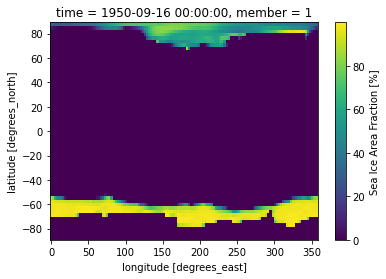

In [44]:
#let's take a quick look at September 1950 in member 1 of CanESM2
CanESM2['sic'].sel(time='1950-09').sel(member=1).plot();

**Now let's plot this with a polar stereographic plot**

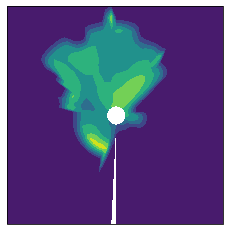

In [45]:
data = CanESM2['sic'].sel(time='1950-09').sel(member=1)

fig = plt.figure() #set the size of the figure
ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=0)) #define the axes in terms of the polar projection
ax.set_extent((-180,180,66,90), ccrs.PlateCarree()) #only include data above the minimum latitude

plt.contourf(data['lon'], data['lat'], data[0].values, transform=ccrs.PlateCarree());

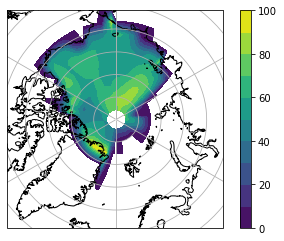

In [46]:
#that didn't look very helpful, let's add some coastlines, gridlines, set the contour levels and add a colorbar
data = CanESM2['sic'].sel(time='1950-09').sel(member=1)

fig = plt.figure() 
ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=0)) 
ax.set_extent((-180,180,66,90), ccrs.PlateCarree()) 

#now add the levels of the contours, note we start just above 0 so we leave blank all the areas without sea ice
plt.contourf(data['lon'], data['lat'], data[0].values, levels=np.arange(0.001,101,10), transform=ccrs.PlateCarree())

ax.coastlines() #add coastlines
ax.gridlines() #add gridlines
plt.colorbar(); #add the default colobar

## Load a function to plot polar stereographic plots
**Matplotlib and Cartopy based plots can get very complicated, therefore I've made a polar stereographic plotting function to make it a lot simpler**

In [47]:
def circular_polar_plot(data, lat_min, colors, title_, no_col_bar=False, 
                        cbar_label=False, levels_=False, cbar_levels_=False, 
                        extend_kw=False, horizontal=False):
    
    '''
    This function requires an input of an xarray dataarray with lat/lon and a third varaible
    
    Parameters
    ----------
    data : a 2D xarray dataarray 
        The data should have latitude and longitude coordinates
    lat_min : integer
        The minimum latitude of the polar projection, in summer typically use 60 and 50 in winter
    colors : string
        See https://matplotlib.org/stable/tutorials/colors/colormaps.html, e.g. 'RdBu' or 'RdBu_r' 
    title_ : string
        The title of the figure
    no_col_bar : bool
        Default True, set to False if no colorabar is required
    cbar_label : string
        Title of the colorbar label
    levels_ : list
        The intervals of the colormap e.g. np.arange(0,101,1) for 0 to 100 with an interval of 1
    cbar_levels_ : list
        The intervals of the colorbar ticks e.g. np.arange(0,101,10) for 0 to 100 with each 10 interval marked on the colorbar
    extend_kw : string
        Which end or ends of the colorbar should be extended ['neither', 'both', 'min', 'max'], defaults to 'both'.
    horizontal : bool
        If true colorbar is horizontal, false for vertical.
        
    
    Returns
    ----------
    maplotlib.pyplot figure instance
    
    '''
    
    #define the overall figure charachteristics
    fig = plt.figure(figsize=[8,8]) #set the size of the figure
    ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=0)) #define the axes in terms of the polar projection
    ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree()) #only include data above the minimum latitude
    
    #make the plot circular using matplotlib.path
    theta = np.linspace(0, 2*np.pi, 100) 
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T #matrix transpose
    circle = mpath.Path(verts * radius + center) #this is now a circle boundary defined in matplotlib
    ax.set_boundary(circle, transform=ax.transAxes) #cut the plot at the circle boundary
    
    if no_col_bar: #we don't include a colorbar if this argument is True
        data.plot(ax=ax,cmap=str(colors), add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())
    else:
        fig.subplots_adjust(right=0.87) #make space at the right side of the plot for the colorbar
        plotting = data.plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

        ####################################### define the colorbar ############################################
        if horizontal: #=True means we want the colobar horizontal
            orient = 'horizontal'
            cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.04]) #this is x,y position of the colorbar and length and height
        else:
            orient = 'vertical'
            cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
        
        #define whether the colorbar should be capped, default if no 'extend_kw' keyword is for both caps to be there so 'extend=both'
        if extend_kw:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation=orient)
        else:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation=orient)
        
        #set the label and label size of the colorbar
        if horizontal:
            cb.ax.set_xlabel(str(cbar_label), fontsize=20)
        else:
            cb.ax.set_ylabel(str(cbar_label), fontsize=20)
    
        cb.ax.tick_params(labelsize=20) #set the tick size on the colobar
        #####################################################################################################
    
    #add details to the figure after the data is plotted
    ax.coastlines() #add coastlines
    ax.gridlines() #add gridlines
    ax.set_title(str(title_), fontsize=20) #set the title and fontzise
    ax.set_facecolor('0.5') #make the background (usually land) gray

In [49]:
#have a look at the arguments required for this function
help(circular_polar_plot)

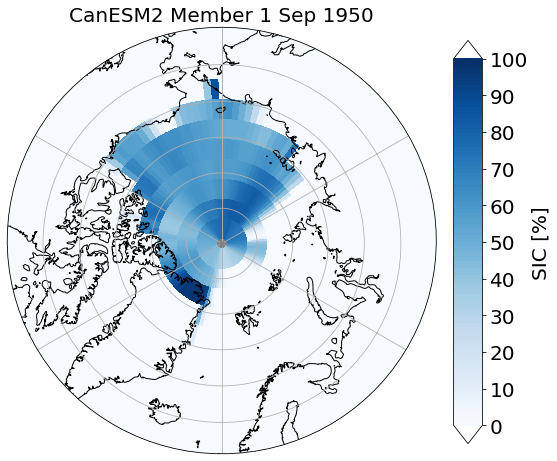

In [50]:
#let's plot the same thing 
circular_polar_plot(data=CanESM2['sic'].sel(time='1950-09').sel(member=1), lat_min=60, colors='Blues',
                    title_='CanESM2 Member 1 Sep 1950', cbar_label='SIC [%]', levels_=np.arange(0,101),
                    cbar_levels_=np.arange(0,101,10))

In [51]:
CanESM2_areacello = xr.open_dataset(data_path+'areacello_CanESM2.nc')

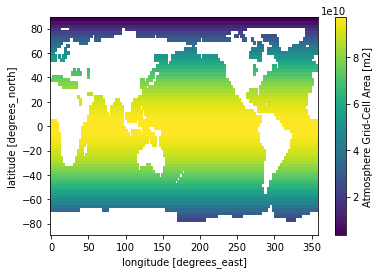

In [52]:
CanESM2_areacello['areacello'].plot()

**Now we can use the areacello file as a mask to exclude the land for our data** <br>
**Below we use the** `.where` **function which convert values where the condition is false into** `np.nan` **values which don't get plotted**

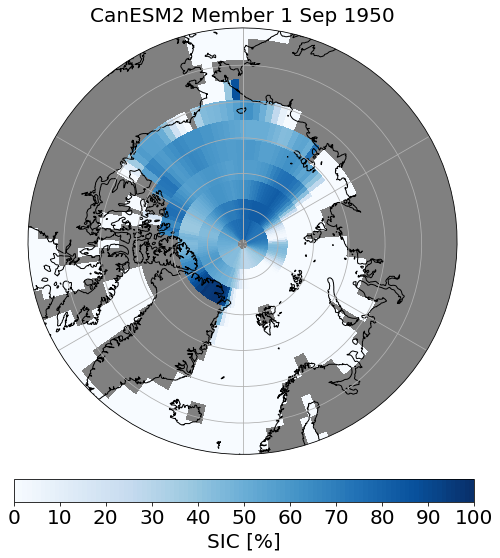

In [53]:
circular_polar_plot(data=CanESM2['sic'].sel(time='1950-09').sel(member=1).where(CanESM2_areacello['areacello'].values > 0), 
                    lat_min=60, colors='Blues', title_='CanESM2 Member 1 Sep 1950', cbar_label='SIC [%]', levels_=np.arange(0,101),
                    cbar_levels_=np.arange(0,101,10), extend_kw='neither', horizontal=True)

## Plot statistics of the CanESM2 large ensemble

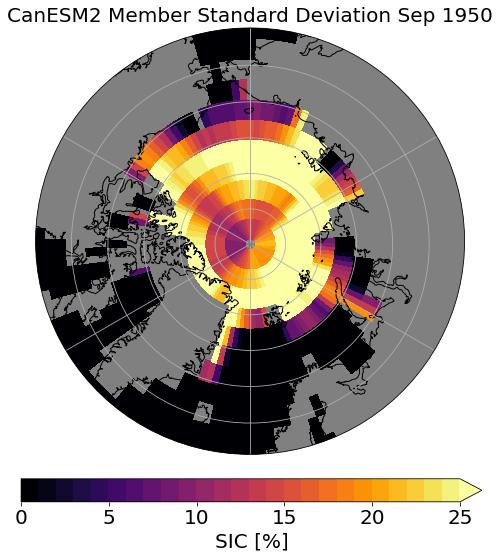

In [54]:
SD_CanESM2_member = CanESM2['sic'].sel(time='1950-09').std('member')

circular_polar_plot(data=SD_CanESM2_member.where(CanESM2_areacello['areacello'].values > 0), 
                    lat_min=60, colors='inferno', title_='CanESM2 Member Standard Deviation Sep 1950', cbar_label='SIC [%]', levels_=np.arange(0,25.1,1),
                    cbar_levels_=np.arange(0,26,5), extend_kw='max', horizontal=True)

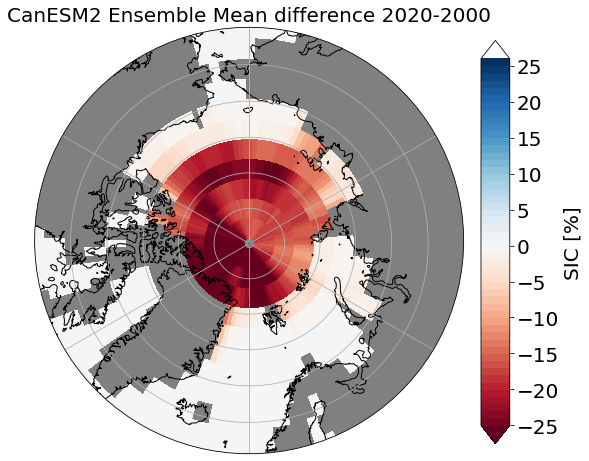

In [64]:
CanESM2_2020_change = CanESM2['sic'].sel(time='2020-09').mean('member') - \
                      CanESM2['sic'].sel(time='2000-09').mean('member').values

circular_polar_plot(data=CanESM2_2020_change.where(CanESM2_areacello['areacello'].values > 0), 
                    lat_min=60, colors='RdBu', title_='CanESM2 Ensemble Mean difference 2020-2000', 
                    cbar_label='SIC [%]', levels_=np.arange(-25,27,1),
                    cbar_levels_=np.arange(-25,26,5))

# Reduced area plots
**Now let's define another plotting function for the reduced area region of Baffin Bay** <br>
**Pay particular note of the** `ax.set_extent` **line where we select the longitudes -90 to -40 and latitudes 58 to 85 to be plotted** 

In [61]:
CESM_07 = xr.open_dataset(data_path+'CESM1_LE_Baffin_Bay_SIC_07_regrid.nc')

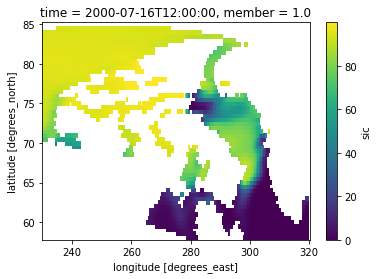

In [62]:
#when plotting this, note we have to transpose the data so longitude is along the x axis
CESM_07['sic'].sel(time='2000').sel(member=1).transpose().plot();

**Add a few more features to this figure to make it easier to read**

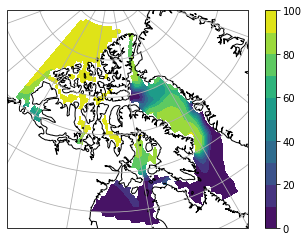

In [65]:
data = CESM_07['sic'].sel(time='2000').sel(member=1)

fig = plt.figure() #initialize the figure to add axes to later

#note here the central longitude is changed
ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=-90)) 
ax.set_extent((-115,-55,58,86), ccrs.PlateCarree()) 

#now add the levels of the contours, note we start just above 0 so we leave blank all the areas without sea ice
plt.contourf(data['lon'], data['lat'], data[0].transpose().values, levels=np.arange(0.001,101,10), transform=ccrs.PlateCarree())

ax.coastlines() #add coastlines
ax.gridlines() #add gridlines
plt.colorbar(); #add the default colobar

**Now let's write a function to incorporate even more functionality, like the** `circular_polar_plot` **function, just for the specific limited area**

In [14]:
def baffin_plot(data, colors, title_, no_col_bar=False, 
                cbar_label=False, levels_=False, cbar_levels_=False, 
                extend_kw=False, horizontal=False):

    #define the overall figure charachteristics
    fig = plt.figure(figsize=[8,8]) #set the size of the figure
    ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=-60)) #define the axes in terms of the polar projection
    ax.set_extent((-90,-40,58,85), ccrs.PlateCarree()) #only include data above the minimum latitude

#     fig.subplots_adjust(right=0.87) #make space at the right side of the plot for the colorbar
    plotting = data.plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

    ####################################### define the colorbar ############################################
    if horizontal: #=True means we want the colobar horizontal
        orient = 'horizontal'
        cbar_ax = fig.add_axes([0.15, 0.05, 0.725, 0.04]) #this is x,y position of the colorbar and length and height
    else:
        orient = 'vertical'
        cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])

    #define whether the colorbar should be capped, default if no 'extend_kw' keyword is for both caps to be there so 'extend=both'
    if extend_kw:
         cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation=orient)
    else:
         cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation=orient)

    #set the label and label size of the colorbar
    if horizontal:
        cb.ax.set_xlabel(str(cbar_label), fontsize=20)
    else:
        cb.ax.set_ylabel(str(cbar_label), fontsize=20)

    cb.ax.tick_params(labelsize=20) #set the tick size on the colobar
    #####################################################################################################

    #add details to the figure after the data is plotted
    ax.coastlines() #add coastlines
    ax.gridlines() #add gridlines
    ax.set_title(str(title_), fontsize=20) #set the title and fontzise
    ax.set_facecolor('0.5') #make the background (usually land) gray

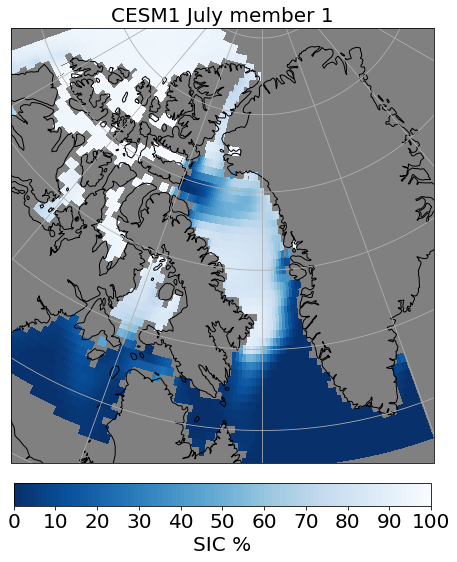

In [67]:
baffin_plot(CESM_07['sic'].sel(time='2000').sel(member=1).transpose(), colors='Blues_r', title_='CESM1 July member 1', cbar_label='SIC %',
            extend_kw='neither', levels_=np.arange(0,101), cbar_levels_=np.arange(0,101, 10), horizontal=True)